In [1]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Set hyperparameters

In [2]:
# output directory
output_dir = 'model_output/rnn'

# training
epochs = 16
batch_size = 128

# vector space embedding
n_dim = 64
n_unique_words = 10000
max_review_length = 100 # lowered due to vanishing gradient over time
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# convolutional layer
n_rnn = 256 # number of neurons in a filter
drop_rnn = 0.2

# dense layer (usually not needed for RNN)
# n_dense = 256
# dropout = 0.2

### Load data

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)                                                       

### Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type,
                        truncating=trunc_type, value=0)

### Design neural network

In [5]:
model = Sequential()

# first hidden layer
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

# second hidden layer
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))

# output layer
model.add(Dense(1, activation='sigmoid'))

2024-03-04 00:58:52.791355: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-04 00:58:52.791375: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-03-04 00:58:52.791379: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-03-04 00:58:52.791406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-04 00:58:52.791422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 64)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               82176     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 722433 (2.76 MB)
Trainable params: 722433 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Configure model

In [7]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Train

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/16


2024-03-04 00:58:53.485674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 702s 4s/step - loss: 0.6956 - accuracy: 0.5348 - val_loss: 0.7540 - val_accuracy: 0.4968
Epoch 2/16


/Users/jaejin/mambaforge/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - ETA: 0s - loss: 0.6736 - accuracy: 0.5754

### Evaluate

In [14]:
model.load_weights(output_dir+"/weights.04.hdf5")

In [15]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 2s 2ms/step


In [16]:
y_hat.shape

(25000, 1)

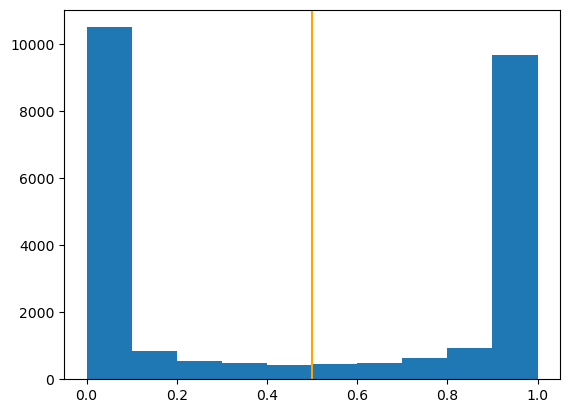

In [17]:
plt.hist(y_hat)
# plt.axvline(x=0.5, color='orange')
_ = plt.axvline(x=0.5, color='orange')

In [18]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat) * 100.0)

'95.96'